# Import libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import InterclusterDistance
from tqdm import tqdm
from yellowbrick.cluster.elbow import kelbow_visualizer
from collections import defaultdict
import re
import string
from datetime import timedelta

Consider at least 10 additional features that can be generated for each user_id (you can use chatGPT or other LLM tools for suggesting features to create). Describe each of them and add them to the previous dataset you made (the one with five features). In the end, you should have for each user at least 15 features (5 recommended + 10 suggested by you).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2 - Grouping user together

## Getting our data

We access data found in this dataset. In our spefic case the **dataset refer to Netflix audience behaviour and UK movies.**
The dataset covers user behaviour on Netflix from users in the UK to opted-in to have their anonymized browsing activity tracked.

It only includes desktop and laptop activity (which Netflix estimate is around 25% of global traffic) and is for a fixed window of time (January 2017 to June 2019, inclusive).

We may remark that data is not trusted by the platform itself but of course is relevant for *media economics.*


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/ADM4/vodclickstream_uk_movies_03.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671736 entries, 0 to 671735
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    671736 non-null  int64  
 1   datetime      671736 non-null  object 
 2   duration      671736 non-null  float64
 3   title         671736 non-null  object 
 4   genres        671736 non-null  object 
 5   release_date  671736 non-null  object 
 6   movie_id      671736 non-null  object 
 7   user_id       671736 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 41.0+ MB


In [ ]:
dat= dataset['datetime']

In [ ]:
# I giorni vanno da 1 a 31
dat.dt.day.describe()

count    671736.000000
mean         15.606907
std           8.833825
min           1.000000
25%           8.000000
50%          16.000000
75%          23.000000
max          31.000000
Name: datetime, dtype: float64

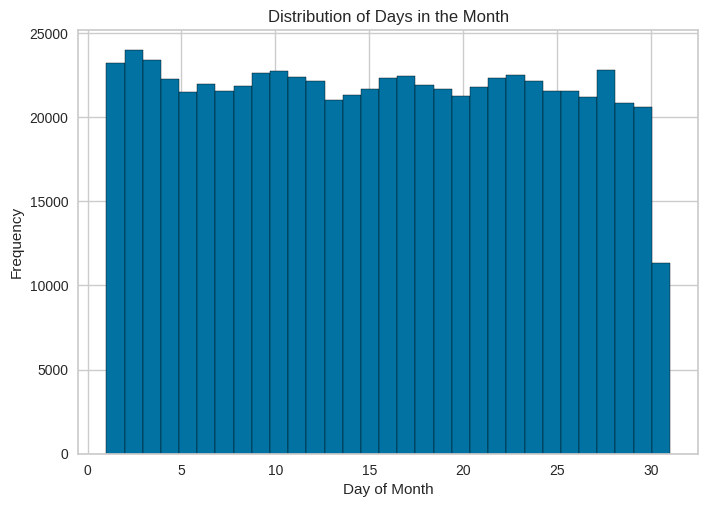

In [ ]:
# Plotting the day component
dataset['datetime'].dt.day.plot(kind='hist', bins=31, edgecolor='black')

# Setting labels and title
plt.xlabel('Day of Month')
plt.ylabel('Frequency')
plt.title('Distribution of Days in the Month')

# Display the plot
plt.show()

In [ ]:
dataset

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id,genres_list,hourofday,oldmovie
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe,"[Comedy, Drama, Romance]",1,True
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510,"[Fantasy, Horror, Mystery, Thriller]",13,False
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf,"[Action, Thriller]",15,False
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6,"[Action, Drama]",16,False
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287,"[Animation, Action, Adventure, Comedy, Family,...",19,True
...,...,...,...,...,...,...,...,...,...,...,...
671731,730504,2019-06-30 21:37:08,851.0,Oprah Presents When They See Us Now,Talk-Show,2019-06-12,43cd23f30f,57501964fd,[Talk-Show],21,False
671732,730505,2019-06-30 21:49:34,91157.0,HALO Legends,"Animation, Action, Adventure, Family, Sci-Fi",2010-02-16,febf42d55f,d4fcb079ba,"[Animation, Action, Adventure, Family, Sci-Fi]",21,False
671733,730506,2019-06-30 22:00:44,0.0,Pacific Rim,"Action, Adventure, Sci-Fi",2013-07-12,7b15e5ada1,4a14a2cd5a,"[Action, Adventure, Sci-Fi]",22,False
671734,730507,2019-06-30 22:04:23,0.0,ReMastered: The Two Killings of Sam Cooke,"Documentary, Music",2019-02-08,52d49c515a,0b8163ea4b,"[Documentary, Music]",22,False


Sometimes, the features (variables, fields) are not given in a dataset but can be created from it; this is known as feature engineering. For example, the original dataset has several clicks done by the same user, so grouping data by user_id will allow you to create new features for each user.


# get all features and store in file.merge

## Get **favorite genre**, according to time spent seeing that genre films (duration)

> To get the favorite genre of a user we first create of set of genres

>and than we count for each user which is the most seen (based on the duration of the films)

As we want to compute the favorite films considering duration we c'è *duration* column.
> **We see there're a lot of 0.0 duration** probably due to the fact that a customer clicked but didn't started watching the film.

There are 350382  empty duration row which we will not consider to retrieve the favorite genre of a user
#### Filter data

In [ ]:
# For each row we have now a list of the genres and store to a new variable in the dataset
dataset['genres_list'] = dataset.genres.apply(lambda row: [word.strip() for word in row.split(',')])

In [ ]:
# Groupby su 'user_id' e filter for 'duration' > 0
#gdf = dataset[dataset['duration']>0.0]
gdf = dataset[dataset['duration'] != '']
#gdf = dataset[dataset['duration'] > 0.0].dropna(subset=['duration'])
gdf['duration'] = pd.to_numeric(gdf['duration'], errors='coerce')
gdf.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id,genres_list
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe,"[Comedy, Drama, Romance]"
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510,"[Fantasy, Horror, Mystery, Thriller]"
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf,"[Action, Thriller]"
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6,"[Action, Drama]"
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287,"[Animation, Action, Adventure, Comedy, Family,..."


As each films has multiple labels referring to the genre we probabily want to make a dictionary from the set of genres created, update the count with the duration if that film belongs to that genre and return the favorite genre for each author.

To get the first feature we will:

1.   Create the dictionary {   (`user_id`, `genre`): `total_duration_spent_for_that_genre`}
2.   From this we create a new vocabulary where we have for each user the maximum duration and all associated genres. It occures to have more that one genres as a film can have multiple labels or more films same maximum duration.

> This dictionary will look like
{`user_id`: [`total_duration`, [ `genre1`,`genre2`,`genre3`]}
3. We convert it to a DataFrame and merge to the gf - dataframe merged by user_id



puoi riscriverlo usando direttamente i dataframe

In [ ]:
# I create a voculary were I store the genre and the total time spent on that genre
# I want to compute it for each athor and I can rewrite it as I
# have the genre and compute stored the favorite genres in the dataset

# Create a defaultdict to store genre durations for each user
genres_dict = defaultdict(int)

# Iterate over rows in gdf
for index, row in gdf.iterrows():
    user_id = row['user_id']
    duration = row['duration']

    # Update the genre durations in the dictionary
    for genre in row['genres_list']:
        genres_dict[user_id, genre] += duration

In [ ]:
genres_dict

defaultdict(int,
            {('7cbcc791bf', 'Action'): 17946.0,
             ('7cbcc791bf', 'Thriller'): 17946.0,
             ('ebf43c36b6', 'Action'): 17056.0,
             ('ebf43c36b6', 'Drama'): 7625.0,
             ('8e1be40e32', 'Drama'): 297894.0,
             ('8e1be40e32', 'History'): 8866.0,
             ('8e1be40e32', 'War'): 8995.0,
             ('cff8ea652a', 'Drama'): 3845.0,
             ('cff8ea652a', 'Horror'): 3845.0,
             ('cff8ea652a', 'Thriller'): 3845.0,
             ('759ae2eac9', 'Comedy'): 6175.0,
             ('759ae2eac9', 'Drama'): 177034.0,
             ('5b1727dc12', 'Animation'): 1339879.0,
             ('5b1727dc12', 'Action'): 40658.0,
             ('5b1727dc12', 'Adventure'): 1339879.0,
             ('5b1727dc12', 'Comedy'): 1392369.0,
             ('5b1727dc12', 'Family'): 1392369.0,
             ('5b1727dc12', 'Fantasy'): 176919.0,
             ('3142b4c730', 'Drama'): 7799.0,
             ('3142b4c730', 'War'): 20613.0,
             ('93e9

In [ ]:
column_fav_genres = defaultdict()
# Iterate over each user
for user,user_genres in genres_dict.keys():
    # Get duration
    duration = genres_dict[user,user_genres]
    #print(duration)
    if user in column_fav_genres:
        if column_fav_genres[user][0] == duration :
            column_fav_genres[user][1].append(user_genres)
        else:
            if column_fav_genres[user][0]>duration:
                column_fav_genres[user] = [column_fav_genres[user][0], [user_genres]]
    else:
        column_fav_genres[user] = [duration, [user_genres]]


In [ ]:
column_fav_genres

defaultdict(None,
            {'1dea19f6fe': [0.0, ['Comedy', 'Drama', 'Romance']],
             '544dcbc510': [18645.0, ['Adventure']],
             '7cbcc791bf': [17946.0, ['Romance']],
             'ebf43c36b6': [17056.0, ['Comedy']],
             'a57c992287': [0.0,
              ['Animation', 'Family', 'Fantasy', 'Short', 'Horror', 'Music']],
             'c5bf4f3f57': [9801.0, ['Adventure']],
             '8e1be40e32': [297894.0, ['Documentary']],
             '892a51dee1': [732.0, ['Sci-Fi']],
             'cff8ea652a': [3845.0, ['Documentary']],
             'bf53608c70': [8400.0, ['Sci-Fi', 'Mystery']],
             '059f371467': [86076.0, ['Mystery']],
             '759ae2eac9': [6175.0, ['Comedy']],
             '37b4e3f352': [0.0,
              ['Biography',
               'Comedy',
               'Drama',
               'Sport',
               'Action',
               'Adventure',
               'Family',
               'Fantasy',
               'Romance']],
             '

In [ ]:
# Creating a new dictionary only for the favorite genres

for user in column_fav_genres.keys():
    column_fav_genres[user] = column_fav_genres[user][1]

In [ ]:
column_fav_genres

defaultdict(None,
            {'1dea19f6fe': ['Comedy', 'Drama', 'Romance'],
             '544dcbc510': ['Adventure'],
             '7cbcc791bf': ['Romance'],
             'ebf43c36b6': ['Comedy'],
             'a57c992287': ['Animation',
              'Family',
              'Fantasy',
              'Short',
              'Horror',
              'Music'],
             'c5bf4f3f57': ['Adventure'],
             '8e1be40e32': ['Documentary'],
             '892a51dee1': ['Sci-Fi'],
             'cff8ea652a': ['Documentary'],
             'bf53608c70': ['Sci-Fi', 'Mystery'],
             '059f371467': ['Mystery'],
             '759ae2eac9': ['Comedy'],
             '37b4e3f352': ['Biography',
              'Comedy',
              'Drama',
              'Sport',
              'Action',
              'Adventure',
              'Family',
              'Fantasy',
              'Romance'],
             '5b1727dc12': ['Romance'],
             '3142b4c730': ['Thriller'],
             'b25918e854'

In [ ]:
fav_genres = pd.DataFrame(column_fav_genres.items(), columns=['user_id','favorite_genres'])

In [ ]:
fav_genres.head()

,user_id,favorite_genres
0,1dea19f6fe,"[Comedy, Drama, Romance]"
1,544dcbc510,[Adventure]
2,7cbcc791bf,[Romance]
3,ebf43c36b6,[Comedy]
4,a57c992287,"[Animation, Family, Fantasy, Short, Horror, Mu..."


In [ ]:
fav_genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161918 entries, 0 to 161917
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   user_id          161918 non-null  object
 1   favorite_genres  161918 non-null  object
dtypes: object(2)
memory usage: 2.5+ MB


## **average click duration**


In [ ]:
average_click = pd.DataFrame()
average_click = average_click.assign(average_click = lambda x :dataset.groupby(by='user_id').duration.mean()).reset_index()

average_click.head()

,user_id,average_click
0,00004e2862,0.000000
1,000052a0a0,2024.166667
2,000090e7c8,0.000000
3,000118a755,-0.250000
4,000296842d,9663.375000


In [ ]:
average_click.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161918 entries, 0 to 161917
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        161918 non-null  object 
 1   average_click  161918 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB



#### **time of day the user spents most of the time**

Time of the day (Morning/Afternoon/Night) when the user spends the most time on the platform (the time spent is tracked through the duration of the clicks)


In [ ]:
dataset.datetime = pd.to_datetime(dataset.datetime)
dataset.release_date = pd.to_datetime(dataset.release_date, errors='coerce')

In [ ]:
dataset['hourofday'] = 0
dataset['hourofday'] = dataset.datetime.dt.hour

dataset.groupby(by=['user_id','hourofday'])


I create a dictionary as the following:
> {`user_id`: `duration_monring`,`duration_afternoon`,`duration_night`}
were all duration as considered as the the sum of the duration if `hourofday` is in the respective bins.

Notice that we are considering only the starting point as information

Furthermore we split a in day in morning, afternoon and night in the following way:

part of the day (hourofday)=
\begin{cases}
\text{morning} \qquad \quad hourofday \in[05,12] \\
\text{afternoon}   \qquad hourofday \in[12,21] \\
\text{night} \qquad \qquad hourofday \in[21,05] \\
\end{cases}


In [ ]:
# Define a dictionary to store each total duration for each part of the day
find_max_duration = defaultdict(lambda: [0,0,0])

# Selecting only row with non-zero duration as it doesn't make sense to sum zero
#dduration = dataset[dataset['duration']>0.0]

# Iterating over this new dataset, I get all necessaty information
for index,row in dataset.iterrows():
    user_id = row['user_id']
    hour = row['hourofday']
    duration = row['duration']
    # Add opportunly
    if 5<=hour<12:
        find_max_duration[user_id][0] += duration
    elif 12<=hour<21:
        find_max_duration[user_id][1] += duration
    elif 21<=hour or hour<5:
        find_max_duration[user_id][2] += duration
find_max_duration

defaultdict(<function __main__.<lambda>()>,
            {'1dea19f6fe': [0, 0, 0.0],
             '544dcbc510': [0, 10933.0, 7712.0],
             '7cbcc791bf': [0, 21496.0, 3816.0],
             'ebf43c36b6': [7524.0, 20729.0, 0],
             'a57c992287': [10937.0, 84861.0, 0],
             'c5bf4f3f57': [0, 15297.0, 0],
             '8e1be40e32': [0, 19923.0, 338773.0],
             '892a51dee1': [0, 2919.0, 0],
             'cff8ea652a': [0, 3845.0, 0.0],
             'bf53608c70': [0, 600.0, 8400.0],
             '059f371467': [0, 3777.0, 86583.0],
             '759ae2eac9': [0, 6175.0, 170896.0],
             '37b4e3f352': [0, 0.0, 0.0],
             '5b1727dc12': [1053941.0, 126306.0, 212122.0],
             '3142b4c730': [0, 0.0, 20613.0],
             'b25918e854': [0, 0.0, 80130.0],
             '2c66cc607c': [0, 0, 767026.0],
             '93e9369e81': [143461.0, 639204.0, 578309.0],
             '5e05d4a6ba': [0, 24601.0, 0.0],
             '78cdb81c4f': [0, 8849.0, 54195.0

In [ ]:
# Create a new dictionary were for each user I return 'Morning/Afternoon/Night'
max_hourofday = defaultdict()

i=0
for id in find_max_duration.keys():
    max_list = find_max_duration[id].index(max(find_max_duration[id]))
    if max_list ==0:
        max_hourofday[id] = 'Morning'
    if max_list ==1:
        max_hourofday[id] = 'Afternoon'
    if max_list ==2:
        max_hourofday[id] = 'Night'

In [ ]:
# Creating a DataFrame from the dictionary
timeofday = pd.DataFrame(list(max_hourofday.items()), columns=['user_id', 'timeofday'])

In [ ]:
timeofday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161918 entries, 0 to 161917
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    161918 non-null  object
 1   timeofday  161918 non-null  object
dtypes: object(2)
memory usage: 2.5+ MB



### **old movie lover/new school user**

Is the user an old movie lover, or is he into more recent stuff (content released after 2010)?

In [ ]:
dataset['oldmovie'] = False
dataset['oldmovie'] = dataset.release_date.dt.year < 2010

# Group by 'user_id' and calculate the sum of True and False for each user
user_preference = dataset.groupby('user_id')['oldmovie'].sum()

oldmovie_df = pd.DataFrame(user_preference).reset_index()
# Create a new column 'oldmovie_preference' based on the condition
oldmovie_df['oldmovie'] = dataset['user_id'].map(user_preference > (dataset.groupby('user_id')['oldmovie'].count() - user_preference))

# Convert the boolean values to 'oldmovies' or 'newmovies'
oldmovie_df['oldmovie'] = oldmovie_df['oldmovie'].map({True: 'oldmovies', False: 'newmovies'})



In [ ]:
oldmovie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161918 entries, 0 to 161917
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   161918 non-null  object
 1   oldmovie  161918 non-null  object
dtypes: object(2)
memory usage: 2.5+ MB


## **average time**
Average time spent a day by the user (considering only the days he logs in)

> we decide not to drop values with 0-duration as they are computed in the mean

In [ ]:
df1 = pd.DataFrame()
df1[['days', 'averagetime_day', 'user_id']] = dataset[['datetime', 'duration', 'user_id']]

# Extract the date from the 'datetime' column
df1['date'] = df1['days'].dt.date

# Group by date and perform your desired aggregation
grouped_data = df1.groupby(by = ['date','user_id']).agg({'averagetime_day': 'mean'}).reset_index().drop(columns=['date'])
# Group by user_id and calculate the mean of 'averagetime_day'
user_avg_data = grouped_data.groupby('user_id')['averagetime_day'].mean().reset_index()


In [ ]:
user_avg_data.head()

,user_id,averagetime_day
0,00004e2862,0.000000
1,000052a0a0,2692.277778
2,000090e7c8,0.000000
3,000118a755,-0.166667
4,000296842d,8599.083333


In [ ]:
user_avg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161918 entries, 0 to 161917
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   user_id          161918 non-null  object 
 1   averagetime_day  161918 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [ ]:
dataset_dropped = dataset.drop(['duration','oldmovie'], axis=1)

merged_df = pd.merge(dataset_dropped, fav_genres, on='user_id')
merged_df = pd.merge(merged_df, average_click, on='user_id')
merged_df = pd.merge(merged_df, oldmovie_df, on='user_id')
merged_df = pd.merge(merged_df, user_avg_data, on='user_id')
merged_df = pd.merge(merged_df, timeofday, on='user_id')

# Drop specified columns
merged_df = merged_df.drop(columns=['genres_list', 'datetime', 'title',
                                    'genres', 'release_date', 'movie_id', 'Unnamed: 0','hourofday'])


need drop duplicate becuase altough dataframe are same, merge does not work properly because favorite_genres is a list

In [ ]:
merged_final = merged_df.drop_duplicates(subset=['user_id'])

In [ ]:
merged_final

,user_id,favorite_genres,average_click,oldmovie,averagetime_day,timeofday,day_of_week
0,1dea19f6fe,"[Comedy, Drama, Romance]",0.000000,newmovies,0.000000,Morning,Sunday
1,544dcbc510,[Adventure],1553.750000,newmovies,1553.750000,Afternoon,Sunday
13,7cbcc791bf,[Romance],4218.666667,newmovies,4661.333333,Afternoon,Sunday
19,ebf43c36b6,[Comedy],1883.533333,newmovies,1885.755556,Afternoon,Sunday
34,a57c992287,"[Animation, Family, Fantasy, Short, Horror, Mu...",3684.538462,newmovies,2854.884615,Afternoon,Sunday
...,...,...,...,...,...,...,...
671731,45414be0ec,"[Comedy, Romance]",0.000000,newmovies,0.000000,Morning,Sunday
671732,783ec67e84,"[Biography, Drama, Sport]",0.000000,newmovies,0.000000,Morning,Sunday
671733,89c715f3a4,"[Animation, Adventure, Comedy, Family, Fantasy...",-1.000000,newmovies,-1.000000,Morning,Sunday
671734,9207e1499b,"[Biography, Crime, Drama]",42592.000000,oldmovies,42592.000000,Night,Sunday


In [ ]:
merged_final.to_json('/content/drive/MyDrive/ADM4/output.json', orient='records', lines=True)

analize the isue to to mergin
- could not select duration>0 - affect averagetime_day
- some genre are not correct - [NOT AVAILABLE]

need to clean it

## *Let's add some more feature*

This should be relevant for to respect to user_day

## **day of the week preference**

We can imagine, and then we prove that on weekend users see more films.

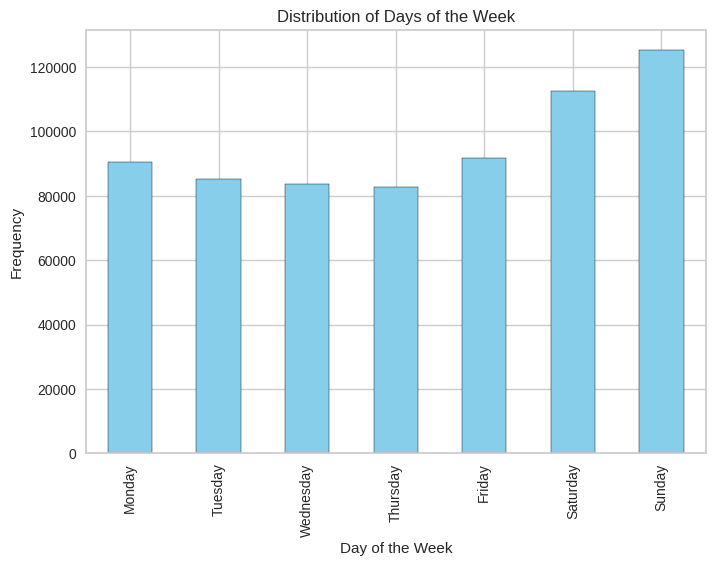

In [ ]:
# Plotting the distribution of days of the week
day_counts = week['day_of_week'].value_counts()
day_counts = day_counts.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

day_counts.plot(kind='bar', edgecolor='black', color='skyblue')

# Setting labels and title
plt.xlabel('Day of the Week')
plt.ylabel('Frequency')
plt.title('Distribution of Days of the Week')

# Display the plot
plt.show()

We define a new *feature* which tells if a user sees film more on weekday or or weekends.

After having stored the feature can

In [ ]:
# Create a new DataFrame 'week' with 'day_of_week' and 'user_id'
week = dataset[['datetime', 'user_id']].copy()
week['day_of_week'] = dataset['datetime'].dt.day_name()
weekend = ['Saturday', 'Sunday']

# map into True/False values if the user watch in the film in the weekend
week['isweekend'] = week['day_of_week'].map(lambda x : x in weekend)
# Group by 'user_id'
weekend_preference = week.groupby('user_id')['isweekend'].sum()
day_count= week.groupby('user_id')['isweekend'].count()

# Column 'weekend' based on the condition normalizing by the number of days
week['weekend'] = week['user_id'].map(
    lambda user_id: (day_count[user_id]/7 < weekend_preference[user_id]/2)
)

In [ ]:
week.drop(columns=['datetime', 'day_of_week','isweekend']).drop_duplicates()

,user_id,weekend
0,1dea19f6fe,True
1,544dcbc510,True
2,7cbcc791bf,True
3,ebf43c36b6,True
4,a57c992287,False
...,...,...
671702,45414be0ec,True
671705,783ec67e84,True
671727,89c715f3a4,True
671730,9207e1499b,True


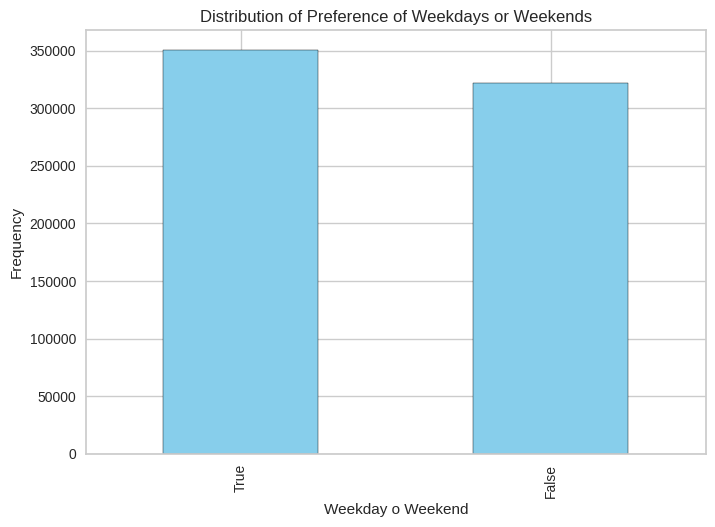

In [ ]:
weekend_weekday= week['weekend'].value_counts()
weekend_weekday.plot(kind='bar', edgecolor='black', color='skyblue')

# Setting labels and title
plt.xlabel('Weekday o Weekend')
plt.ylabel('Frequency')
plt.title('Distribution of Preference of Weekdays or Weekends')

# Display the plot
plt.show()

true =  weekdays<weekends were diequality can interpreted as preference
false = weekends< weekdays were diequality can interpreted as preference

## **english title**

Most of the titles are english also if films are not from UK. Anyway there're non-english titles. It wasbe interesting to see it they will help us for classification

TRANFORM IF SEE MORE ENGLISH FILM THAT NON-ENGLISH.
MAY BE NOT CONSISTANT

## **series film**

number of series of films an user saw

First of all we define a film to be part of a series if:

> in the title there is a number (this decision was taken looking at the unique values of the titles)

In [ ]:
series = dataset[['title','user_id']]

def remove_punctuation(input_string):
    translation_table = str.maketrans("", "", string.punctuation)
    no_punctuation = input_string.translate(translation_table)
    return no_punctuation

def process_title(title):
    # Add your processing logic here
    joined_title = title
    joined_title = re.sub(r"\([^)]*\)|3D|\d{1,3}%|\d{1,2}[,|.]\d{1,3}|\d{2}s|'\d{2}|\d{1,3}%|\d{1,3}[st|th|rd]", '', joined_title)
    joined_title1 = ''.join(remove_punctuation(joined_title).split())
    return not bool(re.match(r'^\d{1,4}|(\ )?[A-Z]?\d{1,6}\ ', joined_title)) and not joined_title1.isalpha()

# Create a new column 'is_series' based on the condition
series['is_series'] = series['title'].apply(process_title)

In [ ]:
series.drop(columns=['title'])

,user_id,is_series
0,1dea19f6fe,False
1,544dcbc510,False
2,7cbcc791bf,False
3,ebf43c36b6,False
4,a57c992287,False
...,...,...
671731,57501964fd,False
671732,d4fcb079ba,False
671733,4a14a2cd5a,False
671734,0b8163ea4b,False


In [ ]:
# Now for each user we count how many series he saw
number_series = pd.DataFrame(series.groupby('user_id')['is_series'].sum()).reset_index()

<Axes: >

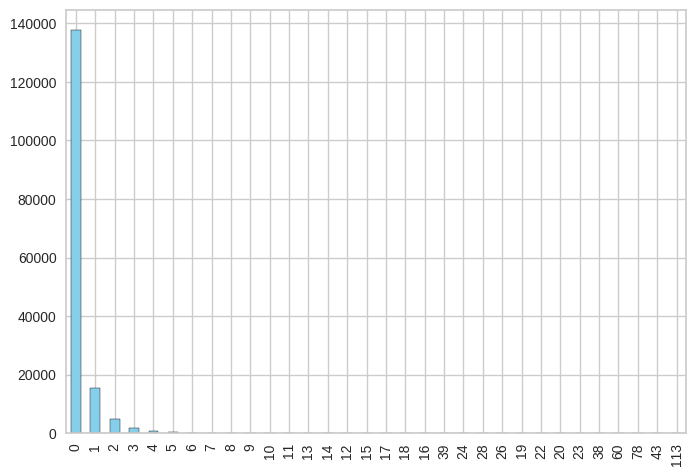

In [ ]:
series_user= number_series['is_series'].value_counts()
series_user.plot(kind='bar', edgecolor='black', color='skyblue')


## **number of films**

In [ ]:
num_films = dataset[['user_id','title']].copy()

num_films['num_films'] = num_films.groupby('user_id')['title'].transform('size')


In [ ]:
num_films.drop(columns=['title']).reset_index(drop=True).drop_duplicates()

,user_id,num_films
0,1dea19f6fe,1
1,544dcbc510,12
2,7cbcc791bf,6
3,ebf43c36b6,15
4,a57c992287,26
...,...,...
671702,45414be0ec,1
671705,783ec67e84,1
671727,89c715f3a4,1
671730,9207e1499b,1


## **number of films of his favorite genres**

## **length of the title**

if users see more film whose title has more than 5 word is True, False otherwise

## **average duration of films seen**

In [ ]:
avg_duratin = dataset['user_id','duration','title']

## **genre diversity**

True if a user see film with more than 6 (to change eventually) films. False if he see less than 6 genres in total (always the same genres)

## **time between clicks**

Calculate the average time between consecutive clicks for each user. Some users might binge-watch content in quick succession, while others may have more spaced-out viewing habits.

## **number of repeted films**

In this feature we analyze how many films on average an user saw more than one time. We computed by the followinf expression:



$$\displaystyle \dfrac{1}{n} \sum_{i=1}^n \text{duration dicotomic} \cdot \left( \text{total film -  unique film}\right)$$

> we compute `total film` counting the number of titles groupbed by `user_id`

> we compute `unique_film` counting the number of unique titles groupbed by `user_id`

> we consider the difference of the two only if  `duration` is non-zero

Therefore we first computed a new variable `duration_dicotomic` defined as:


duration dicotomic=
\begin{cases}
0 \qquad \qquad duration=0 \\
1 \qquad \qquad duration>0 \\
\end{cases}


And we weight this difference by duration as we want to compute only the film which the user actually saw and that that he just clicked (as each row takes into account the clicks).

In [ ]:
dataset['duration_dicotomic'] = dataset['duration'].map(lambda x: 1*(x>0)+ 0*(x==0))
dataset['number_repetition'] = dataset.groupby('user_id')['title'].transform(lambda x: (x.count() - x.nunique())*dataset['duration_dicotomic'])

# Sum for title
dataset['n_repetedfilm'] = dataset.groupby('user_id')['number_repetition'].transform('mean').round()

In [ ]:
avg_repetedfilms = dataset[['user_id','n_repetedfilm']].drop_duplicates()
avg_repetedfilms

,user_id,n_repetedfilm
0,1dea19f6fe,0.0
1,544dcbc510,1.0
2,7cbcc791bf,1.0
3,ebf43c36b6,3.0
4,a57c992287,2.0
...,...,...
671702,45414be0ec,0.0
671705,783ec67e84,0.0
671727,89c715f3a4,0.0
671730,9207e1499b,0.0


<Axes: >

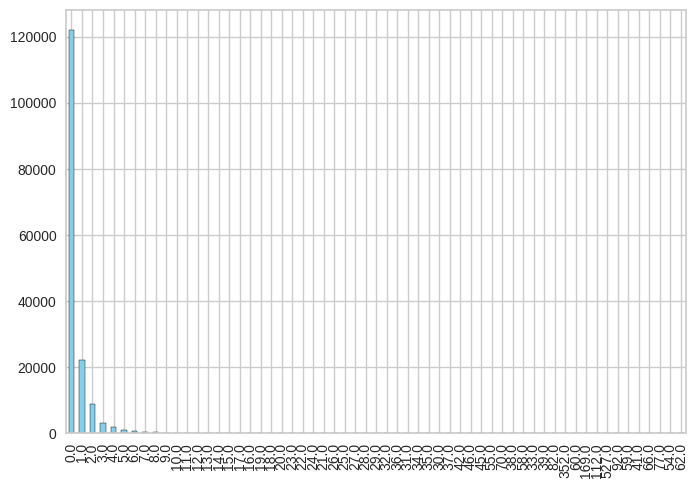

In [ ]:
repetedfilm_user= avg_repetedfilms['n_repetedfilm'].value_counts()
repetedfilm_user.plot(kind='bar', edgecolor='black', color='skyblue')


## **first-day fanatic**

In this new feature we want to store if a user is a first fanatic or not examinig how muchtime from the released_date and the time he saw the film has passed.

Indeed we computed as :

$$\displaystyle \dfrac{1}{n} \sum_{i=1}^n \text{duration dicotomic} \cdot \left( \text{release_date -  datetime}\right)$$

where `n` is the number of films seen by each user.

Notice that it is influnced by how many times saw that film so it can be normalized based on how many time an author has seen that film. It can be interested therefore to compute also that feature, which we're doing next.

In [ ]:
# Extract the date from the 'datetime'
#columndataset = pd.to_datetime(dataset.datetime)
dataset.datetime = pd.to_datetime(dataset.datetime, errors='coerce')
dataset.release_date = pd.to_datetime(dataset.release_date, errors='coerce')

gap_time = dataset[['user_id','datetime','release_date','title']].copy()
gap_time['datetime'] = gap_time['datetime'].dt.date
gap_time['release_date'] = gap_time['release_date'].dt.date
gap_time = gap_time.dropna(subset=['datetime', 'release_date'])

# Calculate the time gap in days
gap_time['gap_time'] = dataset['duration_dicotomic']*(gap_time['datetime'] - gap_time['release_date']).dt.days
gap_time['gap_time_avg'] = gap_time.groupby(['user_id','title'])['gap_time'].transform(lambda x: x.mean() if (x != 0).any() else 0)


In [ ]:
gap_time['gap_time_avg'] = gap_time['gap_time_avg'].round(0)

### TO FIX

In [ ]:
gap_time.drop(columns=['datetime','release_date','gap_time','title']).drop_duplicates()

,user_id,gap_time_avg
0,1dea19f6fe,0.0
1,544dcbc510,0.0
2,7cbcc791bf,303.0
3,ebf43c36b6,569.0
4,a57c992287,0.0
...,...,...
671726,8a764d662c,16.0
671727,89c715f3a4,0.0
671730,9207e1499b,2013.0
671731,57501964fd,18.0


In [ ]:
gap_time['gap_time_avg'].describe()

count    641432.000000
mean       1137.803677
std        2241.895415
min       -1227.000000
25%           0.000000
50%         157.000000
75%        1197.000000
max       35596.000000
Name: gap_time_avg, dtype: float64


# **2.1 - Normalization**


## To normalize or not to normalize

* If we do not normalize the data the covergence will be very slow since features with large scales will dominate. Indeed, the shape of the optimization landscape will become very elongated and the gradient descent will oscillate across the narrow valley. This will lead to a very slow convergence. The algorithm may even fail to converge.
This is why we need to normalize the data. In general there are many more good reason to normalize:
    - The mean performs poorly with outliers, which is not ideal as the mean constitutes a core aspect of regression study

    - Imagine you have a dataset with features, and one feature has a much larger scale than the others then the mean of that particular feature contributes significantly to the overall mean of the dataset. If this feature is irrelevant or less informative, its inflated contribution to the mean might mislead the model. In regression analysis, the mean of the target variable serves as a fundamental baseline prediction.

    - Mean Squared Error (MSE) acts as a pivotal metric, measuring the average squared difference between predicted and actual values. The lower MSE implies superior model performance compared to this basic mean-based prediction.

    - Coefficients in regression models provide insights into the relationship between features and the target variable. Positive coefficients indicate an increase in the feature associates with an increase in the predicted outcome, and vice versa for negative coefficients. These coefficients can be interpreted in the context of the mean of the target variable, offering a reference point for understanding the impact of features on the predicted outcome. Essentially, the mean serves as a starting point for model evaluation and interpretation, providing a benchmark against which the model's predictive power and the significance of individual features can be assessed.

    - Degrees of freedom represent the number of independent values in the dataset. An irrelevant feature with a large scale may effectively reduce the degrees of freedom available for the model to learn meaningful patterns. This reduction in degrees of freedom can hinder the model's capacity to adapt to relevant features.

We can see that even with $\alpha = 0.9$ and 500 iterations the algorithm does not converge if we do not normalize the data.